In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os

from ourfunctions_v3 import clean_nan_samples, try_clf, apply_feature_selection

In [2]:
m = 2000; M = 12000; 
bin_size = 5
step_size = 1; # interpolation step size

path = "D:/GitHub/Machine-Learning/Kaggle/"

In [3]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;

In [4]:
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [5]:
def remove_noise(df):
    N = len(df)  # number of samples
    idx_list = []
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]

        if np.var(intensity) < 100:
          idx_list.append(idx)
          print('Training sample', idx, ' eliminated')
    new_df = df.drop(index = idx_list)
    return new_df

In [6]:
df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated


In [7]:
def interpolate_spectra(df, m, M, step_size):
    # step_size is the size of each step; 1 interpolates very well.
    mz_range = np.arange(m,M+1,step_size)
    
    N = len(df)  # number of samples
    L = len(mz_range)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    idx_list = []
    
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]       
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        interpolated_spectrum = np.interp(x=mz_range,xp=mzcoord,fp=intensity)
        interpolated_spectrum = interpolated_spectrum / np.max(interpolated_spectrum)
        all_data[idx,:] = interpolated_spectrum
    new_df = pd.DataFrame(data=all_data, columns = mz_range, index = df.index)
    plt.show()
    return new_df

In [8]:
# df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = interpolate_spectra(data_train,m,M,step_size)
spectrum_test_train = interpolate_spectra(data_test_train,m,M,step_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

Training samples: 359 and test_train samples: 155
Spectrum interpolated!


Although not for all values the PLS is making it overfit, there is a clear problem: we are using all training data for PLS feature fitting (which involves the targets Y_train) and then performing cross-validation, using as validation set already used data. Therefore, I will now try to implement a pipeline to better cross-validate the classifiers:

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA      
        
def try_clf_pls_pipeline(clf,params,n_cv=5): 
    # Incorporates PLS feature selection and transformations
   
    t1 = time.time()
    
    best_classifiers = [];
    grid_list = [];
    AUC_train = []; AUC_valid = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        
        pca = PCA()
        pip = Pipeline(steps=[('pca',pca),('clf',clf)])
        
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(pip,param_grid=params,scoring='roc_auc',n_jobs=njobs,pre_dispatch='2*n_jobs', cv=n_cv,return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)

        best_clf = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
        AUC_train.append(grid.cv_results_['mean_train_score'][best_clf])
        AUC_valid.append(grid.cv_results_['mean_test_score'][best_clf])

        print('Train AUC: ',np.round(AUC_train[-1],4),' and validation AUC: ',np.round(AUC_valid[-1],4))

    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_valid = np.mean(AUC_valid)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg validation AUC is',np.round(avg_AUC_valid,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_valid

In [13]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', class_weight='balanced')

C_vector = 10. ** np.arange(-1,6)
n_comp_vector = [20,30,40]  #np.arange(14,60,15)
params = {'pca__n_components':n_comp_vector,'clf__C':C_vector}
linear_SVM_best_clfs, grid_list, linear_SVM_AUC_train, linear_SVM_AUC_valid = try_clf_pls_pipeline(clf,params)

['OXACILINA']
The best parameters are:  {'clf__C': 10000.0, 'pca__n_components': 30}
Train AUC:  0.8836  and validation AUC:  0.8235
['AMIKACINA']
The best parameters are:  {'clf__C': 1.0, 'pca__n_components': 40}
Train AUC:  0.8806  and validation AUC:  0.761
['AMOXI/CLAV']


KeyboardInterrupt: 

# TAKES FOREVER (why??)

Automatically created module for IPython interactive environment
Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}


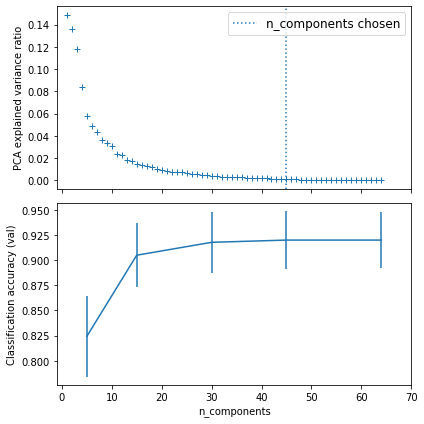

In [87]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()